In [1]:
from src.sift import *
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Estimating the fundamental Matrix
8 points algorithm

7 points algorithm (work in progress)

Robust estimation (work in progress)


## 8-points Algorithm:

In [2]:
def FundamentalM(pairs,min_pts,norm=False):

    Hnorm = HartleysNorm(pairs)
    
    pairs = Hnorm.norm_pairs
    
    idx = np.arange(pairs[0].shape[0])
    
    idx1 = np.random.choice(idx,min_pts)

    x1 = pairs[0][idx1,0]
    y1 = pairs[0][idx1,1]

    x2 = pairs[1][idx1,0]
    y2 = pairs[1][idx1,1]

    A = np.vstack((x2*x1,x2*y1,x2,y2*x1,y2*y1,y2,x1,y1,np.ones(x2.shape)))

    U,S,V = np.linalg.svd(A.T)

    F_ = V[-1].reshape((3,3))

    U,S,V = np.linalg.svd(F_)
    
    S[-1]=0
    
    F = (U.dot(np.diag(S))).dot(V)
       
    F = Hnorm.denormalize(F)
    
    pairs = Hnorm.pairs
    
    e = F_geomError(pairs,F)
      
    return F,e,pairs[0][idx1,:],pairs[1][idx1,:]

# 7-points Algorithm

In [3]:
class mindetF:
    def __init__(self,F1,F2):
        self.F1=F1
        self.F2=F2
    def get_F(self,alpha):
        return alpha*self.F1+(1-alpha)*self.F2
        
    def get_det(self,alpha):
        return np.abs(np.linalg.det(self.get_F(alpha)))
    
    def solve(self):
        minimum = optimize.fmin(self.get_det, 0.9,full_output=False,disp=False)
        #if minimum[0]>=1e-5:print('F7 min greater than 1e-5')
        return self.get_F(minimum[0])

In [4]:
from scipy import optimize

def FundamentalM7pts(pairs,min_pts,norm=False):

    Hnorm = HartleysNorm(pairs)
    
    pairs = Hnorm.norm_pairs
    
    idx = np.arange(pairs[0].shape[0])
    idx1 = np.random.choice(idx,min_pts)

    x1 = pairs[0][idx1,0]
    y1 = pairs[0][idx1,1]

    x2 = pairs[1][idx1,0]
    y2 = pairs[1][idx1,1]


    A = np.vstack((x2*x1,x2*y1,x2,y2*x1,y2*y1,y2,x1,y1,np.ones(x2.shape)))

    U,S,V = np.linalg.svd(A.T)

    F1 = V[-1].reshape((3,3))
    
    F2 = V[-2].reshape((3,3))
    
    f = mindetF(F1,F2)
    
    F = Hnorm.denormalize(F)
    
    pairs = Hnorm.pairs
    
    e = F_geomError(pairs,F)
    
   

    return F,e,pairs[0][idx1,:],pairs[1][idx1,:]

# Hartley's normalization

In [5]:
class HartleysNorm:
    def __init__(self,pairs):
        self.pairs=pairs
        self.Tl = self.get_T(hmg(pairs[0][:,:2]))
        self.Tr = self.get_T(hmg(pairs[1][:,:2]))
        self.norm_pairs = hmg(pairs[0][:,:2]).dot(self.Tl),hmg(pairs[1][:,:2]).dot(self.Tr)
        
    def denormalize(self,F):
        return ((self.Tl.T).dot(F)).dot(self.Tr)
    
    def get_T(self,data):
        ml = data

        n = data.shape[0]

        ml_ = np.mean(ml,axis=0)

        sl = np.sqrt(np.sum((ml - ml_)**2)/(2*n))

        return np.array([[1/sl,0,(-1/sl)*ml_[0]],[0,1/sl,(-1/sl)*ml_[1]],[0,0,1]])


# Robust Estimation

In [6]:
'''
p - probability of being an inlier
k - number of samples
S - number of required trials
'''
def RANSAC2(pairs,min_pts=4,p=0.1,P=.99,th=100,type_='affine',max_it=50000):
    print("Starting RANSAC:")
    S = np.round(np.log(1-P)/(np.log(1-p**min_pts))).astype(int)

    best_fit=0

    for i in range(S):
        if p>0.9:
            break
            
        if type_=='affine':
            w,e,x1,x2 = Affine(pairs,min_pts)
        if type_ == 'F':
            w,e,x1,x2 = FundamentalM(pairs,min_pts,norm=False)
        else:
            w,e,x1,x2 = Homography(pairs,min_pts)

        inliers = np.sum(e<2*th)
        

        if best_fit<inliers:
            best_fit = inliers
            best_w = w
            best_e = np.mean(e)
            best_x1 = x1
            best_x2 = x2
            idx = e<2*th       
            p = best_fit/pairs[0].shape[0]
            print('Iteration: {}'.format(i))
            print(np.mean(e),p,best_fit,pairs[0].shape[0])         
            S += np.round(np.log(1-P)/(np.log(1-p**min_pts))).astype(int)
        
        if i>max_it:
            break

    best_x1 = x1
    best_x2 = x2
    print('RANSAC error: {}'.format(best_e))

    if type_=='affine':
        H = np.reshape(best_w,(2,3))
    elif type_=='F':
        H = np.reshape(best_w,(3,3))
    else:
        H = np.reshape(best_w,(3,3))

    return H,idx

# Helper functions

In [7]:
def hmg(x):
    n = x.shape[0]
    ones = np.ones(n)
    return np.vstack((x.T,ones)).T

In [8]:
def F_geomError(pairs,F):
    
    e1 = (F.dot(hmg(pairs[1][:,:2]).T)).T
    
    e2 = ((hmg(pairs[0][:,:2])).dot(F))

    d1 = np.sum(e1*hmg(pairs[0][:,:2]),axis=1)/np.sqrt(e1[:,0]**2+e1[:,1]**2)
    
    d2 = np.sum(e2*hmg(pairs[1][:,:2]),axis=1)/np.sqrt(e2[:,0]**2+e2[:,1]**2)
        
    return (np.abs(d1)+np.abs(d2)).T



In [9]:
def get_epipoles(F):
    U,S,V = np.linalg.svd(F)
    el = U[-1]
    er = V[-1]
    return el,er

In [10]:
def plot_epip_lines(im1,pairs,F,idx,side='left'):
    img1 = im1.img1_
    
    pairs1 = (pairs[0][idx],pairs[1][idx])
    
    l = (F.dot(hmg(pairs1[1][:,:2]).T)).T
    
    if side=='right':
        #pairs1 = (pairs[1][idx],pairs[0][idx])
        l = (F.T.dot(hmg(pairs1[0][:,:2]).T)).T
        
    num =  pairs1[0].shape[0]

    H,W = img1.shape

    l = l[:,[1,2]]/l[:,0][:,np.newaxis]

    x = np.arange(W)
    lines = []
    for i in range(num):
        y = -l[i,0]*x -l[i,1]
        keep = (y<H-1)&(y>0)
        lines.append((x[keep],y[keep]))

    plt.imshow(img1,**{'cmap':'gray'})

    for i in range(num):
        if side=='left':
            plt.scatter(pairs1[0][i,1],pairs1[0][i,0],c='red',s=10)
        else:
            plt.scatter(pairs1[1][i,1],pairs1[1][i,0],c='red',s=10)
        plt.plot(lines[i][0],lines[i][1],**{'linestyle':'-','linewidth':0.5})
    plt.show()


# Levenberg Marquardt, nlinear optimization

Cost function 11.6

Levenberg-Marquardt A.6.2p600

algorithm A5.6(p595)

$F = M[e]_x$

or

$f = Em$


Minimize $|AEm|$ sbt $|Em|=1$



E = computeE
A = computeA

e <-> Af map: $R^3 -> R^9$


In [184]:
class optimizeF:
    def __init__(self,F,pairs,idx):
        self.pairs = pairs
        self.update_param(F,idx)
        
    def update_param(self,F,idx):
        self.F = F
        self.idx = idx
        U,S,V = np.linalg.svd(F)
        self.pairsx = self.pairs[0][idx],self.pairs[1][idx]
        self.A = self.computeA(self.pairsx)       
        self.e0 = V[-1]

    def J(self,x0):
        fun = self.Af
        step = 1e-4
        delta = np.zeros(x0.shape[0])    
        grad = []
        for i in np.arange(x0.shape[0]):

            delta[i] = step
            x2 = x0 + delta
            x1 = x0 - delta
            increment2 = fun(x2)
            increment1 = fun(x1)
            grad.append((increment2-increment1)/(2*step))
            delta[i] -= step  

        return np.array(grad).T
    
    def computeA(self,pairs):
        x1 = pairs[0][:,0]
        y1 = pairs[0][:,1]

        x2 = pairs[1][:,0]
        y2 = pairs[1][:,1]


        return np.vstack((x2*x1,x2*y1,x2,y2*x1,y2*y1,y2,x1,y1,np.ones(x2.shape))).T

    
    def computeE(self,el):
        zeros = np.zeros((3,3))
        e = np.array([[0,-el[2],el[1]],[el[2],0,-el[0]],[-el[1],el[0],0]])
        e1 = np.hstack([e,zeros,zeros])
        e2 = np.hstack([zeros,e,zeros])
        e3 = np.hstack([zeros,zeros,e])
        return np.vstack((e1,e2,e3))
    
    def Af(self,el):

        F_ = self.f_i(el)

        ei = self.A*F_[np.newaxis,:]

        return np.abs(np.sum(ei,axis=1))
       
    def f_i(self,el):
        r = 6
        E = self.computeE(el)

        U,S,V = np.linalg.svd(E)

        U_ = U[:,:r]

        _,_,V1 = np.linalg.svd(self.A.dot(U_))
        x_ = V1[-1]

        F_ = (U_.dot(x_))
        return F_
    
    def solve(self,factor=10):
        e0 = self.e0
        j = self.J(e0)
        N = j.T.dot(j)
        
        lamb = np.mean(np.diag(N))*1e-3

        ei = self.Af(e0)
        w = np.linalg.solve(N + lamb*np.diag(np.ones(3)),(-j.T).dot(ei))

        dif0 = self.Af(w) - ei
        dif0=dif0.T.dot(dif0)

        for i in range(100):

            j = self.J(e0)
            N = j.T.dot(j)
            ei = self.Af(e0)
            w = np.linalg.solve(N + lamb*np.diag(np.ones(3)),(-j.T).dot(ei))
            dif = self.Af(e0-w) - ei
            dif = dif.T.dot(dif)

            if dif<dif0:
                lamb/=factor
                dif0=dif
                e0 -= w
                
            else:
                lamb*=factor
        
        self.F = np.reshape(self.f_i(e0),(3,3)).T
        #print("Final change in Af: {}".format(dif))
        return self.F
    
    def iter_solve(self,niter=10,factor=10,th=3,diag=False):
        new_idx = self.idx
        init_inliers = np.sum(self.idx)
        best_inliers = 0
        ninliers = []
        
        for i in range(niter):

            self.update_param(self.F,new_idx)
            Fi = self.solve()

            e = F_geomError(pairs,Fi)
            new_idx = e<2*th
            inliers = np.sum(new_idx)
            ninliers.append(inliers)
            
            if best_inliers<inliers:
                best_F = Fi
                best_idx = new_idx
                best_inliers=inliers
            
            if diag==True:print("# inliers: {}".format(inliers))

        print("Initial n of inliers: {}".format(init_inliers))
        print("Final n of inliers: {}".format(ninliers[-1]))
        print("Best inliers: {}".format(best_inliers))
        return best_F,best_idx

# helper - Multiprocessing

In [133]:
import multiprocessing as mp

def worker(kwargs):
    return sift(**kwargs)

def match_kps(kwargs1,kwargs2,NUM_CORE=4):
    
    pool = mp.Pool(NUM_CORE)

    start = time.time()

    list_of_results = pool.map(worker, (kwargs1,kwargs2))

    im1,im2 = list_of_results
    im1==im2
    end = time.time()
    print("total time: {}".format(end-start))
    return im1,im2

# Examples/tests

## House

In [135]:
import time

In [201]:
start = time.time()

kwargs1 = {'img1_':os.path.abspath('img/house/house22.jpg'),'N':2,'Red':2,'s':5,'crt':0.8,'sig':1.6,'RANSAC_th':20,'RANSAC_p':0.3}
kwargs2 = {'img1_':os.path.abspath('img/house/house23.jpg'),'N':2,'Red':2,'s':5,'crt':0.8,'sig':1.6,'RANSAC_th':20,'RANSAC_p':0.3}

im1 = sift(**kwargs1)
im2 = sift(**kwargs2)

im1==im2
end = time.time()
print("total time: {}".format(end-start))

time to get kps: 12.609127759933472
time to get kps: 10.955538034439087
time to match: 30.199281215667725
total time: 54.10027623176575


In [232]:
kwargs1 = {'img1_':os.path.abspath('img/house/house22.jpg'),'N':4,'Red':2,'s':3,'crt':0.5,'sig':1.6,'RANSAC_th':20,'RANSAC_p':0.3}
kwargs2 = {'img1_':os.path.abspath('img/house/house23.jpg'),'N':4,'Red':2,'s':3,'crt':0.5,'sig':1.6,'RANSAC_th':20,'RANSAC_p':0.3}

im1,im2 = match_kps(kwargs1,kwargs2)

time to get kps: 4.022735834121704
time to get kps: 4.617718696594238
time to match: 3.202042579650879
total time: 8.075922966003418


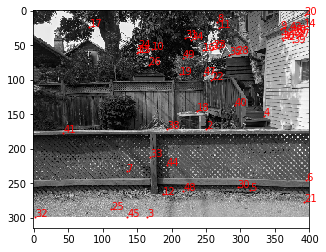

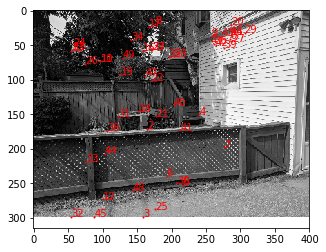

In [233]:
im1.plot('best_kp')
im2.plot('best_kp')

Starting RANSAC:
Iteration: 3
199.76000601515298 0.02 1 50
Iteration: 5
307.613255899188 0.04 2 50
Iteration: 10
102.90958770814962 0.06 3 50
Iteration: 12
426.68324617151507 0.08 4 50
Iteration: 15
56.69593056012269 0.1 5 50
Iteration: 39
40.39574717850343 0.3 15 50
Iteration: 116
38.7464121237623 0.32 16 50
RANSAC error: 38.7464121237623


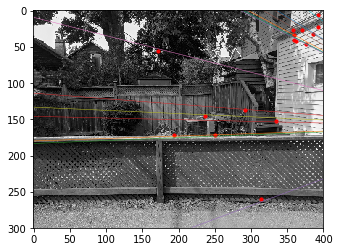

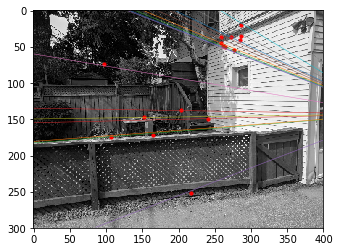

In [234]:
pairs = (im1.best_kp,im2.best_kp)
F,idx = RANSAC2(pairs,min_pts=8,p=0.1,P=.99,th=5,type_='F',max_it=1000)

plot_epip_lines(im1,pairs,F,idx,'left')
plot_epip_lines(im2,pairs,F,idx,'right')

Initial n of inliers: 16
Final n of inliers: 10
Best inliers: 27


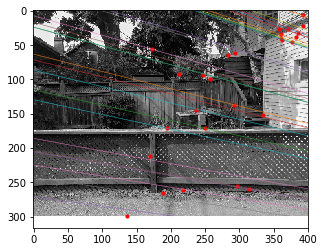

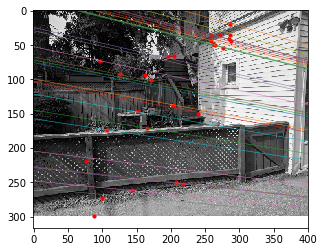

In [235]:
F_ = optimizeF(F,pairs,idx)
Fi,new_idx = F_.iter_solve(th=10,niter=10)

plot_epip_lines(im1,pairs,Fi,new_idx,'left')
plot_epip_lines(im2,pairs,Fi,new_idx,'right')

## Pepsi:

In [203]:
kwargs1 = {'img1_':os.path.abspath('img/pepsi1.jpg'),'type_':"homography",'peak_th':0.08,'crt':0.5,'N':2,'Red':3,'s':3,'sig':1.5,'RANSAC_th':20}
kwargs2 = {'img1_':os.path.abspath('img/pepsi2.jpg'),'type_':"homography",'peak_th':0.08,'crt':0.5,'N':2,'Red':3,'s':3,'sig':1.5,'RANSAC_th':20}

start = time.time()
im3 = sift(**kwargs1)
im4 = sift(**kwargs2)

im3==im4
end = time.time()
print("total time: {}".format(end-start))

time to get kps: 1.823230504989624
time to get kps: 1.8075637817382812
time to match: 0.490478515625
total time: 6.708119630813599


In [221]:
kwargs1 = {'img1_':os.path.abspath('img/pepsi1.jpg'),'type_':"homography",'peak_th':0.08,'crt':0.8,'N':4,'Red':3,'s':5,'sig':1.5,'RANSAC_th':20}
kwargs2 = {'img1_':os.path.abspath('img/pepsi2.jpg'),'type_':"homography",'peak_th':0.08,'crt':0.8,'N':4,'Red':3,'s':5,'sig':1.5,'RANSAC_th':20}

im3,im4 = match_kps(kwargs1,kwargs2)

time to get kps: 6.28364634513855
time to get kps: 6.3647301197052
time to match: 0.6622409820556641
total time: 9.09936809539795


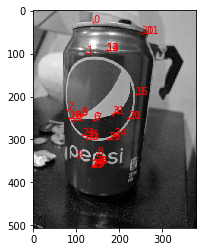

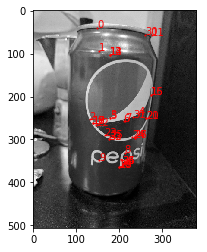

In [222]:
im3.plot('best_kp')
im4.plot('best_kp')

Starting RANSAC:
Iteration: 4
75.18691300556388 0.08108108108108109 3 37
Iteration: 13
60.263313516224756 0.32432432432432434 12 37
Iteration: 32
25.794905897085727 0.3783783783783784 14 37
Iteration: 40
37.895152007429395 0.4594594594594595 17 37
Iteration: 93
19.857150214576485 0.6486486486486487 24 37
Iteration: 206
17.478175401973882 0.7027027027027027 26 37
Iteration: 1238
15.009585546111545 0.7297297297297297 27 37
Iteration: 1598
31.512702696623634 0.7567567567567568 28 37
Iteration: 2350
11.813183587997354 0.9459459459459459 35 37
RANSAC error: 11.813183587997354


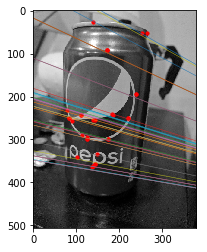

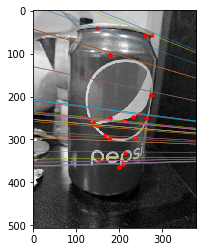

In [223]:
pairs = (im3.best_kp,im4.best_kp)
F,idx = RANSAC2(pairs,min_pts=8,p=0.05,P=.99,th=10,type_='F',max_it=3000)

plot_epip_lines(im3,pairs,F,idx,'left')
plot_epip_lines(im4,pairs,F,idx,'right')

Initial n of inliers: 35
Final n of inliers: 10
Best inliers: 35


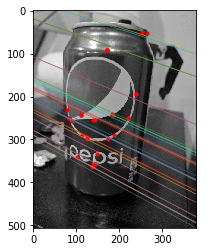

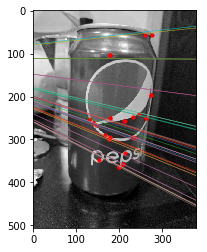

In [224]:
F_ = optimizeF(F,pairs,idx)
Fi,new_idx = F_.iter_solve(niter=10,th=20)

plot_epip_lines(im3,pairs,Fi,new_idx,'left')
plot_epip_lines(im4,pairs,Fi,new_idx,'right')

## Uoft:

In [217]:
kwargs1 = {'img1_':os.path.abspath('img/uoft6.jpg'),'type_':"homography",'peak_th':0.08,'crt':0.8,'N':4,'Red':3,'s':3,'sig':1.5,'RANSAC_th':20}
kwargs2 = {'img1_':os.path.abspath('img/uoft4.jpg'),'type_':"homography",'peak_th':0.08,'crt':0.8,'N':4,'Red':3,'s':3,'sig':1.5,'RANSAC_th':20}

im5,im6 = match_kps(kwargs1,kwargs2)

time to get kps: 3.009200096130371
time to get kps: 3.2832694053649902
time to match: 0.6567623615264893
total time: 6.780167818069458


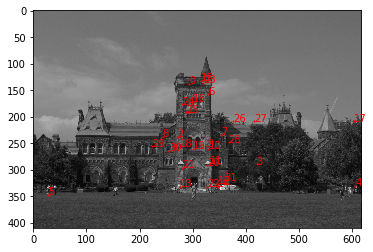

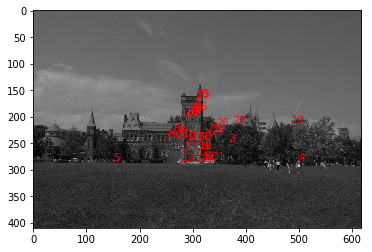

In [218]:
im5.plot('best_kp')
im6.plot('best_kp')

Starting RANSAC:
Iteration: 5
513.4202592752407 0.03125 1 32
Iteration: 6
174.7365115052416 0.0625 2 32
Iteration: 10
30.792006193365914 0.3125 10 32
Iteration: 22
56.37551690215398 0.34375 11 32
Iteration: 217
30.398994910074173 0.375 12 32
Iteration: 269
47.195662661759755 0.4375 14 32
Iteration: 297
22.66667879383868 0.6875 22 32
Iteration: 316
15.68929262137398 0.8125 26 32
RANSAC error: 15.68929262137398


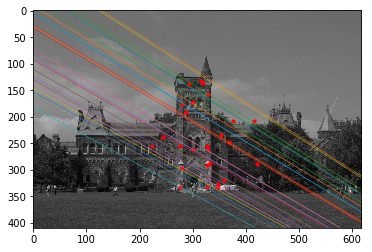

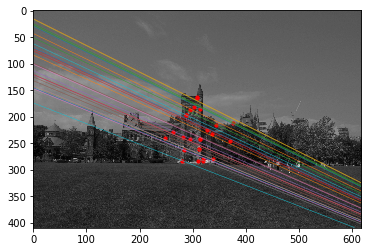

In [219]:
pairs = (im5.best_kp,im6.best_kp)
F,idx = RANSAC2(pairs,min_pts=8,p=0.1,P=.99,th=10,type_='F',max_it=1000)

plot_epip_lines(im5,pairs,F,idx,'left')
plot_epip_lines(im6,pairs,F,idx,'right')

Initial n of inliers: 26
Final n of inliers: 22
Best inliers: 22


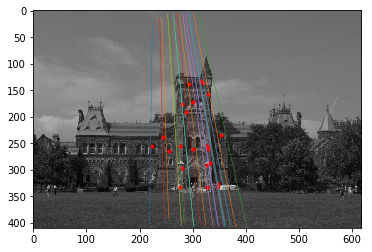

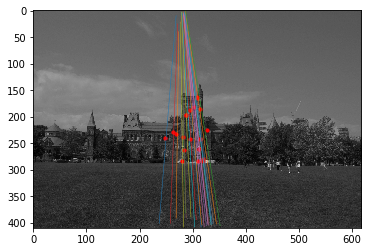

In [220]:
F_ = optimizeF(F,pairs,idx)
Fi,new_idx = F_.iter_solve(niter=10,th=10)

plot_epip_lines(im5,pairs,Fi,new_idx,'left')
plot_epip_lines(im6,pairs,Fi,new_idx,'right')